In [19]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
# import holoviews as hv
# import bokeh
# hv.extension('bokeh')
import pickle as pkl
from scipy.stats import norm
import numpy as np

import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [20]:
NSamp=10000
device = torch.device('cuda:0')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)

In [21]:
with open(f"{home}vine.pkl","rb") as f:
    [covariances,y0,_] = pkl.load(f)
y = norm.cdf(y0)
assert x.shape[0]==y.shape[0]
x.reshape(NSamp,1).shape

ValueError: not enough values to unpack (expected 3, got 2)

In [22]:
with open("/home/nina/CopulaGP/benchmarks/StudentH.pkl","rb") as f:
    data = pkl.load(f)
# x = data[-1]['x']
y = data[-1]['y0']
data[-1]
# import matplotlib.pyplot as plt
# plt.scatter(*y.T)

{'Nvar': 10,
 'NSamp': 10000,
 'true_HRgS': array([8.54773606, 8.54706142, 8.54638678, ..., 6.38379786, 6.3837965 ,
        6.38379514]),
 'true_integral': array([  0.11720445, -15.72077739,   0.02136694]),
 'y': array([[-0.8398547 , -1.00671275, -1.20972214, ..., -0.59468224,
         -1.31047745, -0.75585441],
        [ 1.84325147,  0.07749984,  4.29776248, ...,  1.39172663,
          2.20036561,  0.43156155],
        [-0.77147999,  0.84665626,  1.35529383, ...,  0.03098243,
          2.42349237, -0.98383404],
        ...,
        [ 0.23812884, -1.38315425,  0.02506398, ...,  0.19152044,
         -0.98529367, -0.57415683],
        [ 1.26553429,  1.05093033,  0.69349622, ...,  0.13905519,
          1.40613443,  0.96753805],
        [ 1.50418947,  1.49847957,  0.92132892, ...,  0.48573258,
          1.358202  ,  1.42568436]]),
 'y0': array([[0.24469345, 0.21003733, 0.17498562, ..., 0.30618637, 0.16015353,
         0.26431582],
        [0.89670943, 0.52736006, 0.97495839, ..., 0.8507230

In [28]:
import tqdm

H=200
n_epoch = 5000
data_size = NSamp

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(y.shape[-1], H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
plot_loss = []
for epoch in tqdm.tqdm(range(n_epoch)):
    x_sample=x.reshape(NSamp,1)
    y_sample=y
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor).to(device), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor).to(device), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor).to(device), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.mean(torch.exp(pred_x_y))/torch.exp(torch.ones(1).to(device))
    #torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(-loss.data.cpu().numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 5000/5000 [00:13<00:00, 358.55it/s]


(-0.01, 0.1)

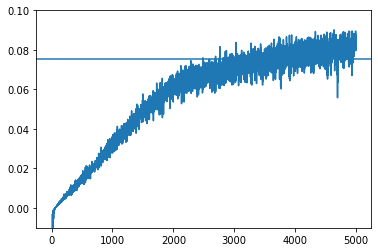

In [29]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)
plt.axhline(data[-1]['integrated'])
plt.ylim(-0.01,0.1)

In [31]:
np.mean(plot_loss[-10:]/np.log(2))

1.0391445